## Import och funktioner

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import joblib

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA


Här valde jag att skala X redan nu. Eftersom att vi vet att maxvärdet är 255 så kan vi utan problem skala det igenom att dela alla värden på 255. Alla värden kommer då att bli mellan 0-1 och eftersom att vi inte använder något medelvärde så riskerar vi heller inget data leakage. Att skala vår data redan nu kommer att spara oss extremt mycket tid i en del modeller där datan annars hade behövts skalas om extremt många gånger.

In [2]:
# Ladda data
mnist = fetch_openml('mnist_784', version=1, cache = True, as_frame = False)
X = mnist["data"]/255.0 #Skalar ner alla features till 0-1
y = mnist["target"].astype(np.uint8)

# Splitta data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
# Funktion för att visualisera confusion matrix senare

def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()

## EDA

 Vi har 70 000 rader och 784 features. Detta stämmer bra eftersom 28X28 = 784
 
 I DESCR kan vi få information om hur datasetet är skapat och annan viktig information som kommer vara väldigt viktig för våran preprocessing av bilder senare.

In [4]:
# Vi har 70 000 rader och 784 features. Detta stämmer bra eftersom 28X28 = 784
print(X.shape)
print(y.shape)

# I DESCR kan vi få information om hur datasetet är skapat och annan viktig information som kommer vara väldigt viktig för våran preprocessing av bilder senare.
print(mnist.DESCR)

(70000, 784)
(70000,)
**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were cente

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.  

With some classification methods (particularly template-based methods, such as SVM and K-nearest neighbors), the error rate improves when the digits are centered by bounding box rather than center of mass. If you do this kind of pre-processing, you should report it in your publications. The MNIST database was constructed from NIST's NIST originally designated SD-3 as their training set and SD-1 as their test set. However, SD-3 is much cleaner and easier to recognize than SD-1. The reason for this can be found on the fact that SD-3 was collected among Census Bureau employees, while SD-1 was collected among high-school students. Drawing sensible conclusions from learning experiments requires that the result be independent of the choice of training set and test among the complete set of samples. Therefore it was necessary to build a new database by mixing NIST's datasets.  

The MNIST training set is composed of 30,000 patterns from SD-3 and 30,000 patterns from SD-1. Our test set was composed of 5,000 patterns from SD-3 and 5,000 patterns from SD-1. The 60,000 pattern training set contained examples from approximately 250 writers. We made sure that the sets of writers of the training set and test set were disjoint. SD-1 contains 58,527 digit images written by 500 different writers. In contrast to SD-3, where blocks of data from each writer appeared in sequence, the data in SD-1 is scrambled. Writer identities for SD-1 is available and we used this information to unscramble the writers. We then split SD-1 in two: characters written by the first 250 writers went into our new training set. The remaining 250 writers were placed in our test set. Thus we had two sets with nearly 30,000 examples each. The new training set was completed with enough examples from SD-3, starting at pattern # 0, to make a full set of 60,000 training patterns. Similarly, the new test set was completed with SD-3 examples starting at pattern # 35,000 to make a full set with 60,000 test patterns. Only a subset of 10,000 test images (5,000 from SD-1 and 5,000 from SD-3) is available on this site. The full 60,000 sample training set is available.

Downloaded from openml.org.

True label for plottet image is 5


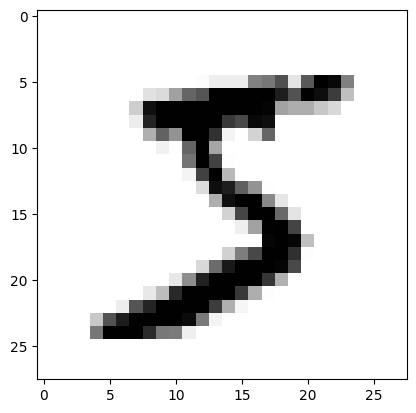

In [5]:
# Visualiserar en klass för att få en känsla av hur de kan se ut
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
print("True label for plottet image is", y[0])

Här nedan ser vi att det finns 256 olika värden i X vilket är bra eftersom det motsvarar mängden nyanser i gråskalan

In [6]:
np.unique(X_train*255)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [7]:
# Gör om till en DataFrame för att göra EDA lättare
y_train_df = pd.DataFrame(y_train)
X_train_df = pd.DataFrame(X_train)

Här ser vi att vi verkar ha bra fördelad träningsdata. Det finns ingen kategori med extremt få mängder.

In [8]:
y_train_df.value_counts()


0
1    6277
7    5790
3    5708
2    5610
0    5560
9    5538
4    5529
6    5480
8    5468
5    5040
Name: count, dtype: int64

## Modellering

Min tanke var att köra en Linjärmodell, en ensemble och en SVM fär att sedan ta den bästa "kategorin" och testa någon mer modell i den kategorin. Några problem jag stötte på var att vissa modeller var alldeles för långsamma. Mer om detta nedan.

In [9]:
models_results = {} # Variabel att spara resultat i för utvärdering

### LogisticRegression

En väldigt simpel modell som gick fort att träna och ändå fick över 90% accuracy

In [10]:

logreg_clf = LogisticRegression()

# Pipeline som från början innehöll standardscaler men nu egentligen är onödig men fick vara kvar eftersom att modellen ändå inte användes
pipeline = Pipeline([
    ("model", logreg_clf)
])

# Crossvalidation
cv = 3

# Hyperparametrar till GridSearch
param_grid = {
    "model__C": [0.01, 0.1, 1],
    "model__max_iter": [1000]
}

# Modell grid
logreg_grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    verbose=1,
    n_jobs=1
)

# Tränar modellen
logreg_grid.fit(X_train, y_train)

# Sparar resultatet
logreg_accuracy = logreg_grid.best_score_
logreg_params = logreg_grid.best_params_
models_results["LogisticRegression"] = {"Best accuracy": round(logreg_accuracy,4)}

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [11]:
print(f"Accuracy: {logreg_accuracy}")
print(f"Best hyperparams: {logreg_params}")

Accuracy: 0.9208749731633441
Best hyperparams: {'model__C': 0.1, 'model__max_iter': 1000}


### ExtraTrees

Eftersom att det gick så fruktansvärt långsamt så var jag tvungen att gå ner till cv 3. Jag kommer därför göra det i alla modeller även de tidigare.

Testade också med max_features och fick sqrt som är standardvalet så valde att bara kommentera bort det för att spara tid men ändå visa på att de varit med tidigare

Denna modellen tog längre tid men fick fina resultat. Hade vi lagt in fler hyperparametrar så hade tiden varit uppe i flera timmar. Jag fick därför begränsa mig rätt mycket i min GridSearch. Kan tillägga att jag och några fler i klassen labbade med hyperparametrarna och kom då fram till att n_estimators 500 var det bästa. Därför testade jag inte vidare efter detta.

In [12]:
extra_trees_clf = ExtraTreesClassifier()

# Pipeline som rensats ut och är onödig nu när data skalas i början istället.
pipeline = Pipeline([
    ("model", extra_trees_clf)
])

# Crossvalidation
cv = 3

# Hyperparametrar till GridSearch
param_grid = {
    "model__n_estimators": [250, 500],
   # "model__max_features": ["sqrt", "log2"]
}

# Modell grid
extra_trees_grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    verbose=1,
    n_jobs=1
)
# Tränar modellen
extra_trees_grid.fit(X_train, y_train)

# Sparar resultatet
extra_trees_accuracy = extra_trees_grid.best_score_
extra_trees_params = extra_trees_grid.best_params_
models_results["ExtraTrees"] = {"Best accuracy": round(extra_trees_accuracy,4)}

Fitting 3 folds for each of 2 candidates, totalling 6 fits


8m 17s med 0.971 accuracy utan PCA


In [13]:
print(f"Accuracy: {extra_trees_accuracy}")
print(f"Best hyperparams: {extra_trees_params}")

Accuracy: 0.971624985313274
Best hyperparams: {'model__n_estimators': 500}


### SVC

SVC blev det en del meck med. Den var alldeles för långsam och min första instinkt var att dömma ut den som för långsam, strunta i den och köra på ExtraTrees eller fortsätta modellera med andra ensemble modeller. Sen gick vi igenom dimensionsreducering och jag insåg då att här har vi lösningen. Så jag körde på det och började med att försöka hitta hur många dimensioner vi skulle ha. Detta visas här nedan

#### PCA exploring

Jag började med en visualisering för hur många dimensioner som förklarade variansen. Här blev min insikt att mellan kanske 70-120 dimensioner såg ut att vara rimligt.

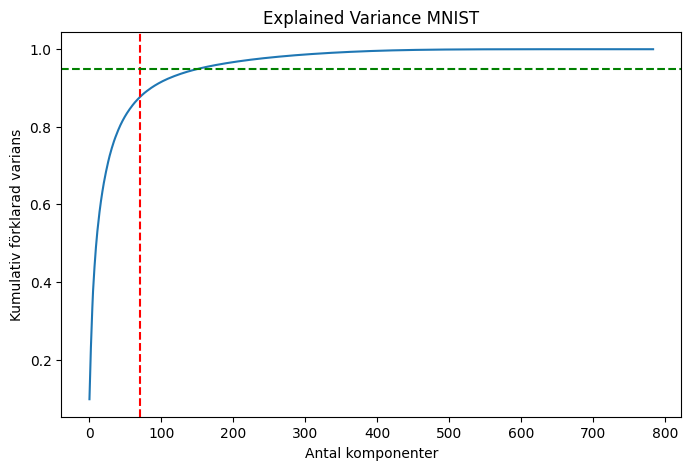

Förklarad varians vid 70 komponenter: 0.8746589597412181


In [14]:
# Träna PCA på träningsdatan
pca = PCA().fit(X_train)

# Kumulativ förklarad varians
cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(cum_var)  # Plotta kumulativ varians

plt.axvline(70, color="red", linestyle="--")   # Markera 70 komponenter
plt.axhline(0.95, color="green", linestyle="--")  # Markera 95% varians

plt.xlabel("Antal komponenter")
plt.ylabel("Kumulativ förklarad varians")
plt.title("Explained Variance MNIST")
plt.show()

# Varians som behålls vid 70 komponenter
print("Förklarad varians vid 70 komponenter:", cum_var[69])


MEN i kapitlet så stod det också om the curse of dimensionality som kortfattat innebär att fler dimensioner ofta blir mer komplext för modellerna vilket leder till att de presterar sämmre. Jag ville då gå vidare och undersöka vilket accuracy score som man fick på de olika dimensionsreduceringarna och kom då fram till att 50 var faktiskt marginellt bättre. Under 50 dimensioner så verkar accuracy sjunka rätt fort och därför kan vi säga att vi hittat vårat målvärde. Nu snackar vi ca 4 tiotusendelar lägre än 70 dimensioner så här jagar vi helt klart marginaler i onödan men oj vad vi lär oss grejer! 

Kan också tillägga att detta har skett iterativt där jag först gjorde en check på variansen och körde 70 dimensioner och på ett mindre urval av data. Då exprimenterade jag med hyperparametrar för att få fram det bästa. Efter det gick jag tillbaka och körde denna koden för att få reda på om 70 dimensioner verkligen var det bästa.

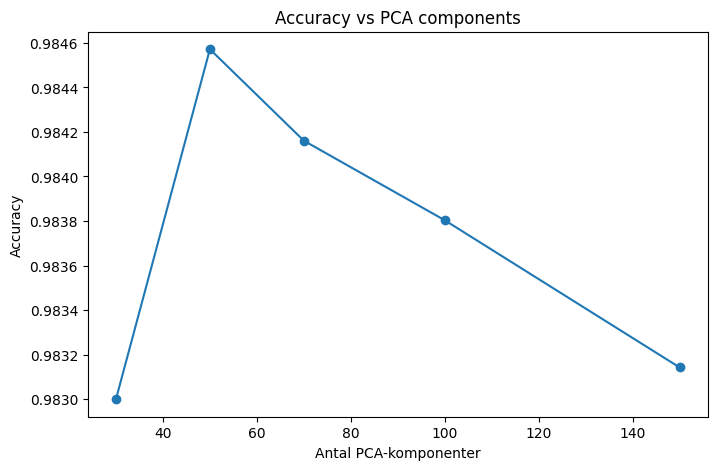

In [15]:
# Lista med antal PCA-komponenter att testa
components = [30, 50, 70, 100, 150]

scores = []

# Loopa över olika antal komponenter
for n in components:
    
    # Skapa pipeline med PCA + SVC
    pipe = Pipeline([
        ("pca", PCA(n_components=n, random_state=42)),
        ("svc", SVC(kernel="rbf", C=10, gamma="scale"))
    ])
    
    # Kör cross validation och ta medel-accuracy
    score = cross_val_score(pipe, X_train, y_train, cv=3, scoring="accuracy").mean()
    
    scores.append(score)

# Plotta accuracy mot antal komponenter
plt.figure(figsize=(8,5))
plt.plot(components, scores, marker="o")

plt.xlabel("Antal PCA-komponenter")
plt.ylabel("Accuracy")
plt.title("Accuracy vs PCA components")

plt.show()

Liten modell för att hitta bra hyperparametrar. Här har jag exprimenterat mycket och det vi ser här är sista körningen där jag scopeat in mig på en riktigt bra modell. Jag insåg också här att jag kan ju köra GridSearch på PCA så det gjorde jag och kom då fram till att 51 var lite bättre än 50 så det kör vi på.

In [16]:
svc_clf = SVC()

# Tar ut 10000 rader för att spara tid vid GridSearchandet.
X_small = X_train[:10000]
y_small = y_train[:10000]

# Pipeline
pipeline = Pipeline([
    ("pca",PCA()),
    ("model", svc_clf)
    ],
)

# Crossvalidation
cv = 3

# Hyperparametrar
param_grid = {
    "pca__n_components": [50,51,52],
    "model__C": [10,11,12],
    "model__kernel" :["rbf"],
    #"model__gamma": ["scale",0.01,0,5]
    "model__gamma": ["scale"]
}

# Modell grid
svc_small_grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    verbose=1,
    n_jobs=1
)
# Tränar modell
svc_small_grid.fit(X_small, y_small)

# Sparar resultat
svc_small_accuracy = svc_small_grid.best_score_
svc_small_params = svc_small_grid.best_params_
models_results["SVC"] = {"Best accuracy": round(svc_small_accuracy,4)}



Fitting 3 folds for each of 9 candidates, totalling 27 fits


{'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
0.9652002092830759

In [17]:
print(svc_small_params)
print(svc_small_accuracy)

{'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf', 'pca__n_components': 52}
0.9656001892930745


Slutgiltliga modellen på hela träningsdatan för att jämföra mot de två andra modellerna. Här har jag tagit bort alla övriga hyperparamterar men kör den såhär för att slippa skriva ny kod och ändå få en CV score.

In [18]:
svc_clf = SVC(probability=True) # Behövs för streamlit appen

# Pipeline
pipeline = Pipeline([
    
    ("pca",PCA(n_components=51)),
    ("model", svc_clf)
])

# Crossvalidation
cv = 3

# Hyperparametrar
param_grid = {
    "model__C": [10],
    "model__kernel" :["rbf"],
    "model__gamma": ["scale"]
}

#Modell grid
svc_grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy", # Behövs för streamlit appen
    verbose=1,
    n_jobs=1
)

# Träna modell
svc_grid.fit(X_train, y_train)

# Spara resultat
svc_accuracy = svc_grid.best_score_
svc_params = svc_grid.best_params_
models_results["SVC"] = {"Best accuracy": round(svc_accuracy,4)}


Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [19]:
print(svc_params)
print(svc_accuracy)

{'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
0.9846606906785712


Här neadan printar jag ut accuracy resultatet från våra olika modeller på vårat träningsdata. Då ser vi att SVC inte bara får bäst resultat utan också blivit den snabbaste tackvare PCA. Vi hade kunnat gå tillbaka och labba med PCA på ExtraTrees för att se om den kan komma ikapp i både tid och accuracy men jag ser inte riktigt meningen med det. SVC har gett ett väldigt bra resultat och dessutom på under 1 minut. Jag beslutar därför att vi går vidare med SVC och dess hyperparamterar som vi kommit fram till med hjälp av gridsearch. Vi börjar med att kolla vår modell mot vår testdata för att se så modellen inte är överanpassad.

In [20]:
df_results = pd.DataFrame(models_results).T
print(df_results)

                    Best accuracy
LogisticRegression         0.9209
ExtraTrees                 0.9716
SVC                        0.9847


Här ser vi att modellen tillomed presterar lite bättre mot vår testdata vilket är väldigt bra. Modellen verkar vara bra generaliserad.

In [21]:
# Plocka ut bästa modellen
best_model = svc_grid.best_estimator_

# Predicera på testdatan
y_pred = best_model.predict(X_test)

# Räkna accuracy
test_accuracy = accuracy_score(y_test, y_pred)

print("Test accuracy:", round(test_accuracy, 4))


Test accuracy: 0.9856


Vill även kolla vad modellen faktiskt har fel på och vi kan se att den faktiskt presterar väldigt bra men att den missat några klassiska missar. Exempelvis tar den 4or för 9or, 5or för 3or och 3or för 2or mer än 10 gånger. Dessa siffror kan vara väldigt lika varandra om de skrivs slarvigt och jag måste säga att jag är väldigt nöjd med detta resultatet.

I övrigt så finns det inte så mycket att säga. Modellen verkar ha marginellt svårare att hitta 9or där recall ligger på 0.97 vilket fortfarande är ett väldigt bra score.

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1343
           1       0.99      0.99      0.99      1600
           2       0.98      0.99      0.98      1380
           3       0.98      0.98      0.98      1433
           4       0.98      0.99      0.98      1295
           5       0.99      0.98      0.99      1273
           6       0.99      0.99      0.99      1396
           7       0.98      0.99      0.99      1503
           8       0.99      0.98      0.98      1357
           9       0.98      0.97      0.98      1420

    accuracy                           0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000



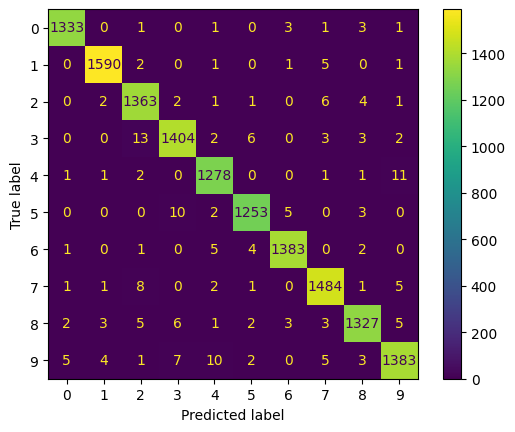

In [22]:
# Kallar på vår tidigare definerad funktion för att få fram en confusion matrix och en classification report
display_confusion_matrix(y_test,y_pred)
print(classification_report(y_test, y_pred))

Jag tränar nu om hela modellen på all data och sparar ner den till nästa del.

In [23]:
# Tränar modellen på all data
final_model = svc_grid.best_estimator_
final_model.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('pca', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",51
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.lin

Sparar modellen

In [24]:
# Sparar modellen
joblib.dump(final_model, "mnist_svc_production")
print("Production model saved!")


Production model saved!
